# Fast Parquet Pipeline (Ultra-Detailed Progress)

Shows:
- Row-level progress per file
- File progress per node/edge type
- Overall progress
- Speed (rows/sec)
- ETA for each step
- Memory usage
- **Complete training pipeline**

In [2]:
# Configuration
import os
import gc
import time
import torch
import glob
import psutil
import pyarrow.parquet as pq
import numpy as np
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple
from IPython.display import display, clear_output

In [4]:
# EXTERNAL DRIVE CONFIGURATION
ROOT_DIR = "/Volumes/Backup Plus/Zaman/graph"
DATA_DIR = os.path.join(ROOT_DIR, "data")
OUTPUT_DIR = os.path.join(ROOT_DIR, "processed_fast")

os.makedirs(OUTPUT_DIR, exist_ok=True)


In [5]:
# Device
DEVICE = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")
print(f"Output: {OUTPUT_DIR}")

Device: mps
Output: /Volumes/Backup Plus/Zaman/graph/processed_fast


In [ ]:


# Node tables: name -> (folder, id_column)
NODE_CONFIG = {
    'pekerja': ('node_pekerja', 'pn'),
    'nasabah': ('node_nasabah', 'cif'),
    'pinjaman': ('node_pinjaman', 'acctno'),
    'simpanan': ('node_simpanan', 'acctno'),
    'transaksi': ('node_transaksi', 'id_trx'),
}

# Edge tables: (src_type, rel, dst_type) -> (folder, src_col, dst_col)
EDGE_CONFIG = {
    ('simpanan', 'debit', 'transaksi'): ('edge_rek_debit', 'src', 'dst'),      # simpanan→transaksi
    ('transaksi', 'credit', 'simpanan'): ('edge_rek_credit', 'src', 'dst'),    # transaksi→simpanan (swapped!)
    ('nasabah', 'has_simpanan', 'simpanan'): ('edge_nasabah_memiliki_simp', 'src', 'dst'),
    ('nasabah', 'has_pinjaman', 'pinjaman'): ('edge_nasabah_memiliki_pinj', 'src', 'dst'),
    ('nasabah', 'is_pekerja', 'pekerja'): ('edge_nasabah_is_pekerja', 'src', 'dst'),
}


Device: mps
Output: /Volumes/Backup Plus/Zaman/graph/processed_fast


In [2]:
# Helper functions
def format_time(s):
    if s < 60:
        return f"{s:.0f}s"
    elif s < 3600:
        return f"{s/60:.1f}m"
    else:
        return f"{s/3600:.1f}h"

def format_number(n):
    if n < 1000:
        return str(n)
    elif n < 1_000_000:
        return f"{n/1000:.1f}K"
    else:
        return f"{n/1_000_000:.1f}M"

def get_memory_mb():
    return psutil.Process().memory_info().rss / 1024 / 1024

def count_parquet_rows(files: List[str]) -> Tuple[int, List[int]]:
    total = 0
    per_file = []
    for f in files:
        try:
            pf = pq.ParquetFile(f)
            n = pf.metadata.num_rows
            total += n
            per_file.append(n)
        except:
            per_file.append(0)
    return total, per_file

---
## Step 1: Build Node Mappings

In [3]:
def build_node_mapping_detailed(node_type: str, folder: str, id_col: str) -> Dict:
    folder_path = os.path.join(DATA_DIR, folder)
    
    if not os.path.exists(folder_path):
        print(f"  Warning: {folder_path} not found")
        return {}
    
    parquet_files = sorted(glob.glob(f"{folder_path}/**/*.parquet", recursive=True))
    if not parquet_files:
        parquet_files = sorted(glob.glob(f"{folder_path}/*.parquet"))
    
    if not parquet_files:
        print(f"  No parquet files found")
        return {}
    
    print(f"  Scanning {len(parquet_files)} files...")
    total_rows, rows_per_file = count_parquet_rows(parquet_files)
    print(f"  Total rows to process: {total_rows:,}")
    
    hash_to_id = {}
    id_to_int = {}
    counter = 0
    rows_processed = 0
    start_time = time.time()
    start_mem = get_memory_mb()
    
    pbar = tqdm(total=total_rows, desc=f"  {node_type}", unit="rows",
                bar_format='{desc}: {percentage:3.1f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]')
    
    for file_idx, pq_file in enumerate(parquet_files):
        try:
            pf = pq.ParquetFile(pq_file)
            for batch in pf.iter_batches(batch_size=100_000, columns=[id_col]):
                ids = batch[id_col].to_pylist()
                batch_size = len(ids)
                
                for id_val in ids:
                    if id_val is None:
                        continue
                    id_str = str(id_val)
                    h = hash(id_str)
                    
                    if h not in hash_to_id:
                        hash_to_id[h] = id_str
                        id_to_int[id_str] = counter
                        counter += 1
                
                rows_processed += batch_size
                pbar.update(batch_size)
                
                elapsed = time.time() - start_time
                speed = rows_processed / elapsed if elapsed > 0 else 0
                mem = get_memory_mb() - start_mem
                
                pbar.set_postfix({
                    'file': f"{file_idx+1}/{len(parquet_files)}",
                    'unique': format_number(counter),
                    'speed': f"{speed:,.0f}/s",
                    'mem': f"+{mem:.0f}MB",
                }, refresh=True)
                
                del ids
        except Exception as e:
            print(f"\n  Error in file: {e}")
            continue
    
    pbar.close()
    elapsed = time.time() - start_time
    print(f"  Done: {counter:,} unique nodes in {format_time(elapsed)}")
    
    del hash_to_id
    gc.collect()
    return id_to_int

In [4]:
print("=" * 70)
print("STEP 1: BUILDING NODE MAPPINGS")
print("=" * 70)

NODE_MAPS = {}
total_start = time.time()

for i, (node_type, (folder, id_col)) in enumerate(NODE_CONFIG.items()):
    print(f"\n[{i+1}/{len(NODE_CONFIG)}] {node_type.upper()}")
    NODE_MAPS[node_type] = build_node_mapping_detailed(node_type, folder, id_col)
    gc.collect()

print("\n" + "=" * 70)
print("NODE MAPPING SUMMARY")
for nt, m in NODE_MAPS.items():
    print(f"  {nt:12s}: {len(m):>12,} nodes")
print(f"Total time: {format_time(time.time() - total_start)}")

STEP 1: BUILDING NODE MAPPINGS

[1/5] PEKERJA
  Scanning 13 files...
  Total rows to process: 62,764


  pekerja: 0.0%|          | 0/62764 [00:00<?, ?rows/s]

  Done: 6,250 unique nodes in 0s

[2/5] NASABAH
  Scanning 13 files...
  Total rows to process: 171,424,448


  nasabah: 0.0%|          | 0/171424448 [00:00<?, ?rows/s]

  Done: 12,270,075 unique nodes in 2.9m

[3/5] PINJAMAN
  Scanning 13 files...
  Total rows to process: 15,031,555


  pinjaman: 0.0%|          | 0/15031555 [00:00<?, ?rows/s]

  Done: 1,524,589 unique nodes in 21s

[4/5] SIMPANAN
  Scanning 13 files...
  Total rows to process: 250,968,941


  simpanan: 0.0%|          | 0/250968941 [00:00<?, ?rows/s]

  Done: 15,636,712 unique nodes in 5.6m

[5/5] TRANSAKSI
  Scanning 13 files...
  Total rows to process: 365,820,399


  transaksi: 0.0%|          | 0/365820399 [00:00<?, ?rows/s]

  Done: 185,262,274 unique nodes in 8.1h

NODE MAPPING SUMMARY
  pekerja     :        6,250 nodes
  nasabah     :   12,270,075 nodes
  pinjaman    :    1,524,589 nodes
  simpanan    :   15,636,712 nodes
  transaksi   :  185,262,274 nodes
Total time: 8.3h


In [5]:
import pickle

MAP_DIR = "/Volumes/Backup Plus/Zaman/graph/map_id"

NODE_MAPS = {}

# Load all node maps
for node_type in ['pekerja', 'nasabah', 'pinjaman', 'simpanan']:
    path = f"{MAP_DIR}/map_{node_type}.pkl"
    with open(path, 'rb') as f:
        NODE_MAPS[node_type] = pickle.load(f)
    print(f"{node_type}: {len(NODE_MAPS[node_type]):,} nodes")

# Load transaksi from partial files and merge
transaksi_map = {}
for part in ['part-0-1', 'part-0-2']:
    path = f"{MAP_DIR}/map_transaksi_{part}.pkl"
    with open(path, 'rb') as f:
        part_map = pickle.load(f)
        transaksi_map.update(part_map)
        print(f"transaksi {part}: {len(part_map):,} nodes")

NODE_MAPS['transaksi'] = transaksi_map
print(f"\ntransaksi total: {len(NODE_MAPS['transaksi']):,} nodes")
print("\nDone! All NODE_MAPS loaded.")

pekerja: 6,250 nodes
nasabah: 12,270,075 nodes
pinjaman: 1,524,589 nodes
simpanan: 15,636,712 nodes
transaksi part-0-1: 92,631,150 nodes
transaksi part-0-2: 92,631,124 nodes

transaksi total: 185,262,274 nodes

Done! All NODE_MAPS loaded.


In [8]:
# Debug: Compare ID formats between node maps and edge files
import pyarrow.parquet as pq
import os

DATA_DIR = "/Volumes/Backup Plus/Zaman/graph/data"

# Sample edge file IDs
edge_file = os.path.join(DATA_DIR, "edge_nasabah_is_pekerja")
pf = pq.ParquetFile(f"{edge_file}/ds=202308.parquet")  # or whatever file exists
batch = next(pf.iter_batches(batch_size=5, columns=['src', 'dst']))

print("Edge file sample (src=cif, dst=pn):")
print(f"  src: {batch['src'].to_pylist()}")
print(f"  dst: {batch['dst'].to_pylist()}")

# Sample from node maps
print("\nNode map sample:")
print(f"  nasabah (first 3): {list(NODE_MAPS['nasabah'].keys())[:3]}")
print(f"  pekerja (first 3): {list(NODE_MAPS['pekerja'].keys())[:3]}")

# Check types
src_sample = str(batch['src'].to_pylist()[0])
print(f"\nEdge src type: {type(batch['src'].to_pylist()[0])}, value: '{src_sample}'")
print(f"Node map key type: {type(list(NODE_MAPS['nasabah'].keys())[0])}")

# Check if src exists in node map
print(f"\nDoes '{src_sample}' exist in nasabah map? {src_sample in NODE_MAPS['nasabah']}")

Edge file sample (src=cif, dst=pn):
  src: ['SJ69172', 'I521632', 'CB81646', 'R523993', 'R329060']
  dst: [26154, 26811, 27812, 27981, 54881]

Node map sample:
  nasabah (first 3): ['DDRE586', 'LA80939', 'SNOJ721']
  pekerja (first 3): [327681, 131094, 131096]

Edge src type: <class 'str'>, value: 'SJ69172'
Node map key type: <class 'str'>

Does 'SJ69172' exist in nasabah map? True


In [9]:
# Convert all node map keys to strings for consistent matching
for node_type in NODE_MAPS:
    NODE_MAPS[node_type] = {str(k): v for k, v in NODE_MAPS[node_type].items()}
    print(f"{node_type}: converted to string keys")

print("\nSample after conversion:")
print(f"  pekerja keys: {list(NODE_MAPS['pekerja'].keys())[:3]}")

pekerja: converted to string keys
nasabah: converted to string keys
pinjaman: converted to string keys
simpanan: converted to string keys
transaksi: converted to string keys

Sample after conversion:
  pekerja keys: ['327681', '131094', '131096']


---
## Step 2: Build Edge Indices

In [10]:
import time
def build_edge_index_detailed(edge_key, folder, src_col, dst_col, src_map, dst_map):
    folder_path = os.path.join(DATA_DIR, folder)
    
    if not os.path.exists(folder_path):
        print(f"  Warning: {folder_path} not found")
        return np.array([], dtype=np.int64), np.array([], dtype=np.int64)
    
    parquet_files = sorted(glob.glob(f"{folder_path}/**/*.parquet", recursive=True))
    if not parquet_files:
        parquet_files = sorted(glob.glob(f"{folder_path}/*.parquet"))
    
    if not parquet_files:
        return np.array([], dtype=np.int64), np.array([], dtype=np.int64)
    
    print(f"  Scanning {len(parquet_files)} files...")
    total_rows, _ = count_parquet_rows(parquet_files)
    print(f"  Total edges to process: {total_rows:,}")
    
    src_list, dst_list = [], []
    valid_count = 0
    rows_processed = 0
    start_time = time.time()
    
    pbar = tqdm(total=total_rows, desc=f"  {edge_key[1]}", unit="edges",
                bar_format='{desc}: {percentage:3.1f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]')
    
    for file_idx, pq_file in enumerate(parquet_files):
        try:
            pf = pq.ParquetFile(pq_file)
            for batch in pf.iter_batches(batch_size=100_000, columns=[src_col, dst_col]):
                src_ids = batch[src_col].to_pylist()
                dst_ids = batch[dst_col].to_pylist()
                batch_size = len(src_ids)
                
                for s, d in zip(src_ids, dst_ids):
                    if s is None or d is None:
                        continue
                    s_idx = src_map.get(str(s))
                    d_idx = dst_map.get(str(d))
                    if s_idx is not None and d_idx is not None:
                        src_list.append(s_idx)
                        dst_list.append(d_idx)
                        valid_count += 1
                
                rows_processed += batch_size
                pbar.update(batch_size)
                
                elapsed = time.time() - start_time
                speed = rows_processed / elapsed if elapsed > 0 else 0
                valid_pct = 100 * valid_count / max(rows_processed, 1)
                
                pbar.set_postfix({
                    'file': f"{file_idx+1}/{len(parquet_files)}",
                    'valid': format_number(valid_count),
                    'valid%': f"{valid_pct:.1f}%",
                    'speed': f"{speed:,.0f}/s",
                })
                
                del src_ids, dst_ids
        except Exception as e:
            print(f"\n  Error: {e}")
    
    pbar.close()
    print(f"  Done: {valid_count:,} valid edges in {format_time(time.time()-start_time)}")
    
    return np.array(src_list, dtype=np.int64), np.array(dst_list, dtype=np.int64)

In [15]:
print("\n" + "=" * 70)
print("STEP 2: BUILDING EDGE INDICES")
print("=" * 70)

EDGE_INDICES = {}
total_start = time.time()

for i, (edge_key, (folder, src_col, dst_col)) in enumerate(EDGE_CONFIG.items()):
    src_type, rel, dst_type = edge_key
    print(f"\n[{i+1}/{len(EDGE_CONFIG)}] {src_type} --[{rel}]--> {dst_type}")
    
    if src_type not in NODE_MAPS or dst_type not in NODE_MAPS:
        print(f"  Skipping: missing node map")
        continue
    
    src_idx, dst_idx = build_edge_index_detailed(
        edge_key, folder, src_col, dst_col,
        NODE_MAPS[src_type], NODE_MAPS[dst_type]
    )
    
    if len(src_idx) > 0:
        EDGE_INDICES[edge_key] = (src_idx, dst_idx)
    gc.collect()

print("\n" + "=" * 70)
print("EDGE INDEX SUMMARY")
for ek, (s, d) in EDGE_INDICES.items():
    print(f"  {ek[1]:20s}: {len(s):>12,} edges")
print(f"Total time: {format_time(time.time() - total_start)}")


STEP 2: BUILDING EDGE INDICES

[1/5] simpanan --[debit]--> transaksi
  Scanning 13 files...
  Total edges to process: 6,290,060


  debit: 0.0%|          | 0/6290060 [00:00<?, ?edges/s]

  Done: 5,470,193 valid edges in 43.4m

[2/5] transaksi --[credit]--> simpanan
  Scanning 13 files...
  Total edges to process: 6,333,648


  credit: 0.0%|          | 0/6333648 [00:00<?, ?edges/s]

  Done: 5,510,986 valid edges in 43.8m

[3/5] nasabah --[has_simpanan]--> simpanan
  Scanning 13 files...
  Total edges to process: 187,998,402


  has_simpanan: 0.0%|          | 0/187998402 [00:00<?, ?edges/s]

  Done: 187,998,376 valid edges in 9.9m

[4/5] nasabah --[has_pinjaman]--> pinjaman
  Scanning 13 files...
  Total edges to process: 13,038,290


  has_pinjaman: 0.0%|          | 0/13038290 [00:00<?, ?edges/s]

  Done: 12,682,596 valid edges in 36s

[5/5] nasabah --[is_pekerja]--> pekerja
  Scanning 13 files...
  Total edges to process: 64,591


  is_pekerja: 0.0%|          | 0/64591 [00:00<?, ?edges/s]

  Done: 64,110 valid edges in 0s

EDGE INDEX SUMMARY
  debit               :    5,470,193 edges
  credit              :    5,510,986 edges
  has_simpanan        :  187,998,376 edges
  has_pinjaman        :   12,682,596 edges
  is_pekerja          :       64,110 edges
Total time: 1.7h


---
## Step 3: Build HeteroData

In [ ]:
from torch_geometric.data import HeteroData
from torch_geometric.utils import degree

print("\n" + "=" * 70)
print("STEP 3: BUILDING HETERODATA WITH DEGREE FEATURES")
print("=" * 70)

data = HeteroData()

# Add nodes with degree features (not random!)
print("\nAdding nodes...")
for node_type, node_map in NODE_MAPS.items():
    num_nodes = len(node_map)
    if num_nodes > 0:
        data[node_type].num_nodes = num_nodes
        # Placeholder - will add degree features after edges
        data[node_type].x = torch.randn(num_nodes, 1)
        print(f"  {node_type}: {num_nodes:,} nodes")

print("\nAdding edges...")
for edge_key, (src_idx, dst_idx) in EDGE_INDICES.items():
    if len(src_idx) > 0:
        edge_index = torch.stack([
            torch.tensor(src_idx, dtype=torch.long),
            torch.tensor(dst_idx, dtype=torch.long)
        ])
        data[edge_key].edge_index = edge_index
        print(f"  {edge_key[1]}: {len(src_idx):,} edges")

# Now add degree features
print("\nComputing degree features...")
for node_type in data.node_types:
    num_nodes = data[node_type].num_nodes
    features = []
    
    for etype in data.edge_types:
        src_type, rel, dst_type = etype
        ei = data[etype].edge_index
        
        # In-degree
        if dst_type == node_type and ei.shape[1] > 0:
            deg = degree(ei[1], num_nodes=num_nodes).unsqueeze(1)
            features.append(deg)
        
        # Out-degree
        if src_type == node_type and ei.shape[1] > 0:
            deg = degree(ei[0], num_nodes=num_nodes).unsqueeze(1)
            features.append(deg)
    
    if features:
        feat = torch.cat(features, dim=1).float()
        feat = (feat - feat.mean(0)) / (feat.std(0) + 1e-6)
        feat = torch.cat([feat, torch.randn(num_nodes, 8)], dim=1)
    else:
        feat = torch.randn(num_nodes, 16)
    
    data[node_type].x = feat
    print(f"  {node_type}: {feat.shape[1]} features")

print("\n✅ HeteroData built with degree features!")

In [6]:
from torch_geometric.utils import degree
import gc

print("\n" + "=" * 70)
print("STEP 3: LOADING HETERODATA & ADDING FEATURES (MEMORY EFFICIENT)")
print("=" * 70)

# Load existing HeteroData
data = torch.load(os.path.join(OUTPUT_DIR, "heterodata.pt"))

print("Loaded HeteroData:")
for nt in data.node_types:
    print(f"  {nt}: {data[nt].num_nodes:,} nodes")

def compute_degree_chunked(edge_index, num_nodes, chunk_size=10_000_000):
    """Compute degree for large graphs in chunks to save memory."""
    deg = torch.zeros(num_nodes, dtype=torch.float32)
    
    total_edges = edge_index.shape[1]
    for start in range(0, total_edges, chunk_size):
        end = min(start + chunk_size, total_edges)
        chunk = edge_index[1, start:end]  # destination nodes
        deg.scatter_add_(0, chunk, torch.ones(chunk.size(0)))
    
    return deg

print("\nComputing degree features for each node type...")

for node_type in data.node_types:
    num_nodes = data[node_type].num_nodes
    features = []
    
    print(f"\n  Processing {node_type} ({num_nodes:,} nodes)...")
    
    for etype in data.edge_types:
        src_type, rel, dst_type = etype
        ei = data[etype].edge_index
        
        # In-degree (receiving edges)
        if dst_type == node_type and ei.shape[1] > 0:
            print(f"    {rel} in-degree...", end=" ")
            if num_nodes > 50_000_000:  # Large node type
                deg = compute_degree_chunked(ei, num_nodes)
            else:
                deg = degree(ei[1], num_nodes=num_nodes)
            features.append(deg.unsqueeze(1))
            print(f"✓ (avg: {deg.mean().item():.2f})")
            del deg
            gc.collect()
        
        # Out-degree (sending edges)
        if src_type == node_type and ei.shape[1] > 0:
            print(f"    {rel} out-degree...", end=" ")
            if num_nodes > 50_000_000:
                # Swap indices for out-degree
                ei_swapped = torch.stack([ei[1], ei[0]])
                deg = compute_degree_chunked(ei_swapped, num_nodes)
            else:
                deg = degree(ei[0], num_nodes=num_nodes)
            features.append(deg.unsqueeze(1))
            print(f"✓ (avg: {deg.mean().item():.2f})")
            del deg
            gc.collect()
    
    # Create feature tensor
    if features:
        # For huge nodes, use float16 to save memory
        if num_nodes > 10_000_000:
            feat = torch.cat(features, dim=1).half()  # float16
        else:
            feat = torch.cat(features, dim=1).float()
        
        # Normalize (handle zeros)
        std = feat.std(0)
        std[std == 0] = 1
        feat = (feat - feat.mean(0)) / std
        
        # Add small random component (only for smaller node types)
        if num_nodes < 1_000_000:
            feat = torch.cat([feat, torch.randn(num_nodes, 4).half() if num_nodes > 10_000_000 else torch.randn(num_nodes, 4)], dim=1)
    else:
        # Minimal features for disconnected nodes
        if num_nodes > 10_000_000:
            feat = torch.randn(num_nodes, 4, dtype=torch.float16)
        else:
            feat = torch.randn(num_nodes, 8)
    
    data[node_type].x = feat
    print(f"    → {feat.shape[1]} features, dtype={feat.dtype}")
    
    # Clear memory
    del features
    gc.collect()

print("\n✅ All features computed!")


STEP 3: LOADING HETERODATA & ADDING FEATURES (MEMORY EFFICIENT)
Loaded HeteroData:
  pekerja: 6,250 nodes
  nasabah: 12,270,075 nodes
  pinjaman: 1,524,589 nodes
  simpanan: 15,636,712 nodes
  transaksi: 185,262,274 nodes

Computing degree features for each node type...

  Processing pekerja (6,250 nodes)...
    is_pekerja in-degree... ✓ (avg: 10.26)
    → 5 features, dtype=torch.float32

  Processing nasabah (12,270,075 nodes)...
    has_simpanan out-degree... ✓ (avg: 15.32)
    has_pinjaman out-degree... ✓ (avg: 1.03)
    is_pekerja out-degree... ✓ (avg: 0.01)
    → 3 features, dtype=torch.float16

  Processing pinjaman (1,524,589 nodes)...
    has_pinjaman in-degree... ✓ (avg: 8.32)
    → 1 features, dtype=torch.float32

  Processing simpanan (15,636,712 nodes)...
    debit out-degree... ✓ (avg: 0.35)
    credit in-degree... ✓ (avg: 0.35)
    has_simpanan in-degree... ✓ (avg: 12.02)
    → 3 features, dtype=torch.float16

  Processing transaksi (185,262,274 nodes)...
    debit in-de

---
## Step 4: Save Checkpoint

In [17]:
import pickle

print("\n" + "=" * 70)
print("STEP 4: SAVING CHECKPOINT")
print("=" * 70)

checkpoint_path = os.path.join(OUTPUT_DIR, "heterodata.pt")
torch.save(data, checkpoint_path)
print(f"Saved HeteroData to {checkpoint_path}")

maps_path = os.path.join(OUTPUT_DIR, "node_maps.pkl")
with open(maps_path, 'wb') as f:
    pickle.dump(NODE_MAPS, f)
print(f"Saved node maps to {maps_path}")


STEP 4: SAVING CHECKPOINT
Saved HeteroData to /Volumes/Backup Plus/Zaman/graph/processed_fast/heterodata.pt


: 

: 

: 

In [1]:
# Test imports
import torch
print(f"PyTorch: {torch.__version__}")

try:
    import pyg_lib
    print(f"pyg-lib: OK")
except ImportError as e:
    print(f"pyg-lib: FAILED - {e}")

try:
    import torch_sparse
    print(f"torch-sparse: OK")
except ImportError as e:
    print(f"torch-sparse: FAILED - {e}")

try:
    import torch_scatter
    print(f"torch-scatter: OK")
except ImportError as e:
    print(f"torch-scatter: FAILED - {e}")

PyTorch: 2.3.0
pyg-lib: FAILED - No module named 'pyg_lib'
torch-sparse: OK
torch-scatter: OK


In [3]:
import torch
import os

OUTPUT_DIR = "/Volumes/Backup Plus/Zaman/graph/processed_fast"

# Load the saved HeteroData
data = torch.load(os.path.join(OUTPUT_DIR, "heterodata.pt"))

print("✅ Loaded HeteroData!")
print(f"Node types: {data.node_types}")
print(f"Edge types: {data.edge_types}")

for nt in data.node_types:
    print(f"  {nt}: {data[nt].num_nodes:,} nodes")
for et in data.edge_types:
    print(f"  {et[1]}: {data[et].edge_index.shape[1]:,} edges")

✅ Loaded HeteroData!
Node types: ['pekerja', 'nasabah', 'pinjaman', 'simpanan', 'transaksi']
Edge types: [('simpanan', 'debit', 'transaksi'), ('transaksi', 'credit', 'simpanan'), ('nasabah', 'has_simpanan', 'simpanan'), ('nasabah', 'has_pinjaman', 'pinjaman'), ('nasabah', 'is_pekerja', 'pekerja')]
  pekerja: 6,250 nodes
  nasabah: 12,270,075 nodes
  pinjaman: 1,524,589 nodes
  simpanan: 15,636,712 nodes
  transaksi: 185,262,274 nodes
  debit: 5,470,193 edges
  credit: 5,510,986 edges
  has_simpanan: 187,998,376 edges
  has_pinjaman: 12,682,596 edges
  is_pekerja: 64,110 edges


---
## Step 5: Verification

In [4]:
print("\n" + "=" * 70)
print("STEP 5: VERIFICATION")
print("=" * 70)

print("\nNode Statistics:")
for ntype in data.node_types:
    print(f"  {ntype}: {data[ntype].num_nodes:,} nodes")

print("\nEdge Statistics:")
for etype in data.edge_types:
    print(f"  {etype[1]}: {data[etype].edge_index.shape[1]:,} edges")

print("\nEdge Validation:")
for etype in data.edge_types:
    ei = data[etype].edge_index
    if ei.shape[1] == 0:
        continue
    src_type, _, dst_type = etype
    valid = ei[0].max() < data[src_type].num_nodes and ei[1].max() < data[dst_type].num_nodes
    print(f"  {etype[1]}: {'VALID' if valid else 'INVALID'}")


STEP 5: VERIFICATION

Node Statistics:
  pekerja: 6,250 nodes
  nasabah: 12,270,075 nodes
  pinjaman: 1,524,589 nodes
  simpanan: 15,636,712 nodes
  transaksi: 185,262,274 nodes

Edge Statistics:
  debit: 5,470,193 edges
  credit: 5,510,986 edges
  has_simpanan: 187,998,376 edges
  has_pinjaman: 12,682,596 edges
  is_pekerja: 64,110 edges

Edge Validation:
  debit: VALID
  credit: VALID
  has_simpanan: VALID
  has_pinjaman: VALID
  is_pekerja: VALID



EDA 1: GRAPH STRUCTURE

📊 NODE COUNTS:
  pekerja        :           6,250
  nasabah        :      12,270,075
  pinjaman       :       1,524,589
  simpanan       :      15,636,712
  transaksi      :     185,262,274

  TOTAL          :     214,699,900

📊 EDGE COUNTS:
  debit               :       5,470,193
  credit              :       5,510,986
  has_simpanan        :     187,998,376
  has_pinjaman        :      12,682,596
  is_pekerja          :          64,110


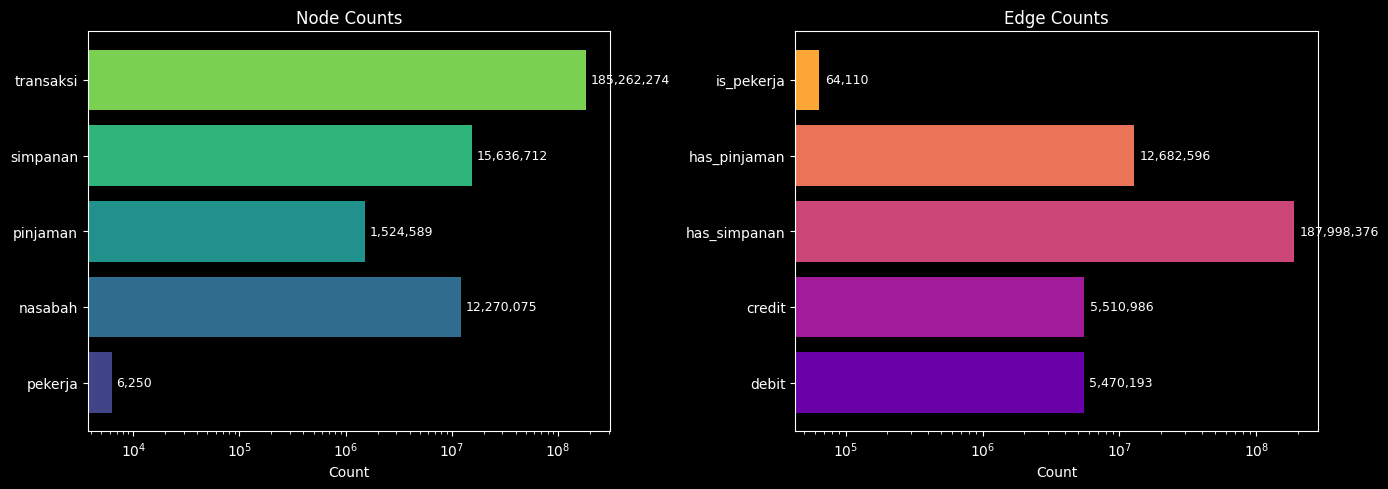

In [9]:
# ============================================================================
# EDA 1: GRAPH STRUCTURE ANALYSIS
# ============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle

plt.style.use('dark_background')

# Load pekerja map
MAP_DIR = "/Volumes/Backup Plus/Zaman/graph/map_id"
DATA_DIR = "/Volumes/Backup Plus/Zaman/graph/data"

with open(f"{MAP_DIR}/map_pekerja.pkl", 'rb') as f:
    pekerja_map = pickle.load(f)
pekerja_map = {str(k): v for k, v in pekerja_map.items()}

print("\n" + "=" * 70)
print("EDA 1: GRAPH STRUCTURE")
print("=" * 70)

# Node counts
print("\n📊 NODE COUNTS:")
node_counts = {}
for nt in data.node_types:
    count = data[nt].num_nodes
    node_counts[nt] = count
    print(f"  {nt:15s}: {count:>15,}")
print(f"\n  {'TOTAL':15s}: {sum(node_counts.values()):>15,}")

# Edge counts
print("\n📊 EDGE COUNTS:")
edge_counts = {}
for et in data.edge_types:
    count = data[et].edge_index.shape[1]
    edge_counts[et[1]] = count
    print(f"  {et[1]:20s}: {count:>15,}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ax = axes[0]
bars = ax.barh(list(node_counts.keys()), list(node_counts.values()), color=plt.cm.viridis(np.linspace(0.2, 0.8, 5)))
ax.set_xlabel('Count'); ax.set_title('Node Counts'); ax.set_xscale('log')
for bar, val in zip(bars, node_counts.values()):
    ax.text(val * 1.1, bar.get_y() + bar.get_height()/2, f'{val:,}', va='center', fontsize=9)

ax = axes[1]
bars = ax.barh(list(edge_counts.keys()), list(edge_counts.values()), color=plt.cm.plasma(np.linspace(0.2, 0.8, 5)))
ax.set_xlabel('Count'); ax.set_title('Edge Counts'); ax.set_xscale('log')
for bar, val in zip(bars, edge_counts.values()):
    ax.text(val * 1.1, bar.get_y() + bar.get_height()/2, f'{val:,}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/eda_graph_structure.png", dpi=150)
plt.show()


EDA 2: FRAUD DISTRIBUTION

📊 LABEL DISTRIBUTION:
  Non-Fraud: 5,722 (91.55%)
  Fraud:     528 (8.45%)
  Imbalance: 10.8:1


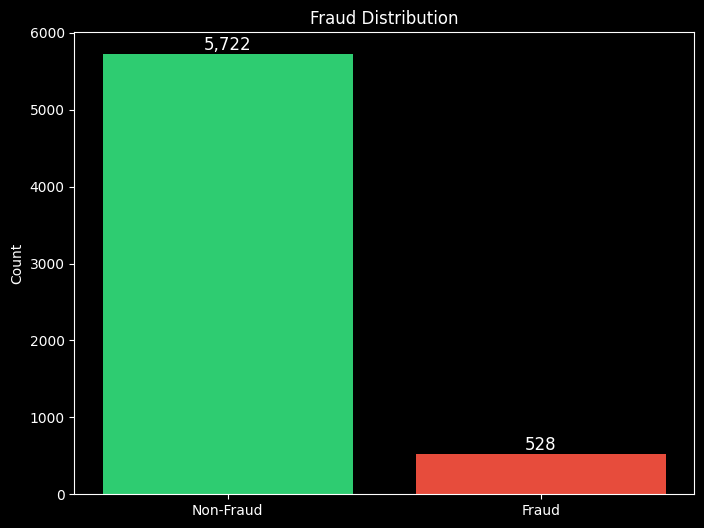


📊 FRAUD BY YEAR:
year
2015.0     17027
2016.0      2239
2017.0      3782
2018.0      9406
2019.0     53262
2020.0    148719
2021.0    286988
2022.0    786391
2023.0    353601
2024.0    266166
2025.0     23295
Name: count, dtype: int64


In [10]:
# ============================================================================
# EDA 2: FRAUD LABEL DISTRIBUTION
# ============================================================================
print("\n" + "=" * 70)
print("EDA 2: FRAUD DISTRIBUTION")
print("=" * 70)

fraud_df = pd.read_csv(f"{DATA_DIR}/labeled_fraud.csv", low_memory=False)
fraud_pns = set(fraud_df['PN'].dropna().astype(str).unique())
num_pekerja = data['pekerja'].num_nodes

fraud_labels = torch.zeros(num_pekerja, dtype=torch.long)
for pn in fraud_pns:
    if pn in pekerja_map:
        idx = pekerja_map[pn]
        if idx < num_pekerja:
            fraud_labels[idx] = 1

n_fraud = fraud_labels.sum().item()
n_nonfraud = num_pekerja - n_fraud

print(f"\n📊 LABEL DISTRIBUTION:")
print(f"  Non-Fraud: {n_nonfraud:,} ({100*n_nonfraud/num_pekerja:.2f}%)")
print(f"  Fraud:     {n_fraud:,} ({100*n_fraud/num_pekerja:.2f}%)")
print(f"  Imbalance: {n_nonfraud/n_fraud:.1f}:1")

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(['Non-Fraud', 'Fraud'], [n_nonfraud, n_fraud], color=['#2ecc71', '#e74c3c'])
ax.set_ylabel('Count'); ax.set_title('Fraud Distribution')
for bar, val in zip(bars, [n_nonfraud, n_fraud]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:,}', ha='center', va='bottom', fontsize=12)
plt.savefig(f"{OUTPUT_DIR}/eda_fraud_distribution.png", dpi=150)
plt.show()

# Temporal
if 'Awal Fraud Terjadi' in fraud_df.columns:
    fraud_df['year'] = pd.to_datetime(fraud_df['Awal Fraud Terjadi'], errors='coerce').dt.year
    print("\n📊 FRAUD BY YEAR:")
    print(fraud_df['year'].value_counts().sort_index())


EDA 3: CONNECTIVITY PATTERNS

📊 NASABAH PER PEKERJA:
  Non-Fraud: mean=10.02, std=4.93
  Fraud:     mean=12.85, std=3.02

📊 SIMPANAN PER PEKERJA:
  Non-Fraud: mean=776.23
  Fraud:     mean=1249.49

📊 TRANSACTIONS PER PEKERJA:
  Non-Fraud: mean=1531.49
  Fraud:     mean=2062.78


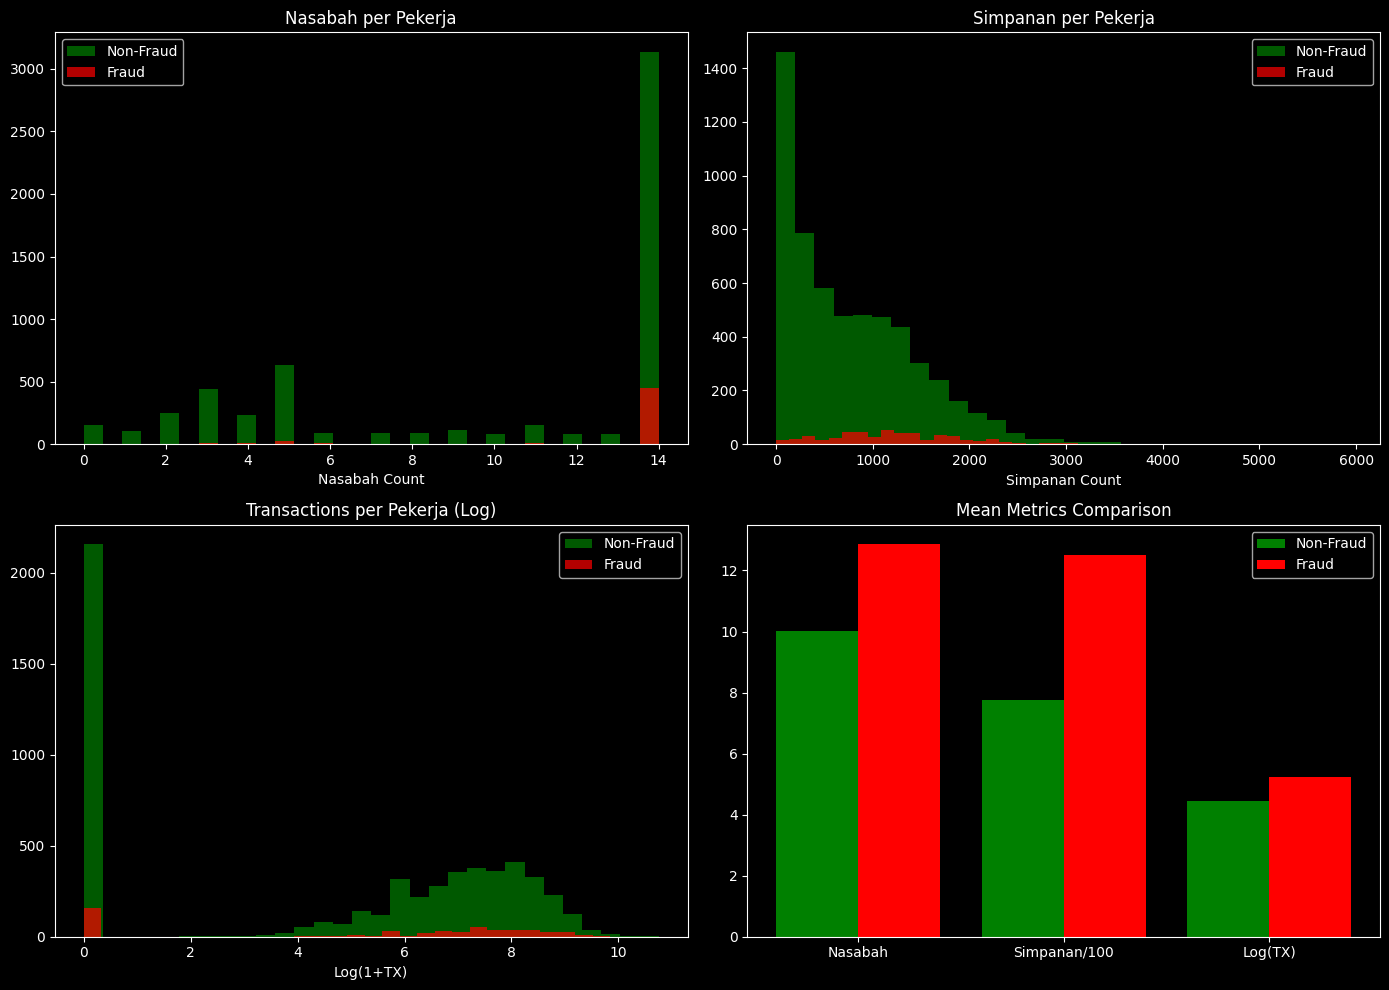

In [11]:
# ============================================================================
# EDA 3: DEGREE & CONNECTIVITY ANALYSIS
# ============================================================================
from torch_geometric.utils import degree

print("\n" + "=" * 70)
print("EDA 3: CONNECTIVITY PATTERNS")
print("=" * 70)

is_pekerja_edge = data[('nasabah', 'is_pekerja', 'pekerja')].edge_index
has_simpanan_edge = data[('nasabah', 'has_simpanan', 'simpanan')].edge_index
debit_edge = data[('simpanan', 'debit', 'transaksi')].edge_index
credit_edge = data[('transaksi', 'credit', 'simpanan')].edge_index

# Nasabah per pekerja
nasabah_per_pekerja = degree(is_pekerja_edge[1], num_nodes=num_pekerja)

fraud_mask = fraud_labels == 1
nonfraud_mask = fraud_labels == 0

print(f"\n📊 NASABAH PER PEKERJA:")
print(f"  Non-Fraud: mean={nasabah_per_pekerja[nonfraud_mask].mean():.2f}, std={nasabah_per_pekerja[nonfraud_mask].std():.2f}")
print(f"  Fraud:     mean={nasabah_per_pekerja[fraud_mask].mean():.2f}, std={nasabah_per_pekerja[fraud_mask].std():.2f}")

# Simpanan aggregated to pekerja
num_nasabah = data['nasabah'].num_nodes
num_simpanan = data['simpanan'].num_nodes
simpanan_per_nasabah = torch.zeros(num_nasabah)
simpanan_per_nasabah.scatter_add_(0, has_simpanan_edge[0], torch.ones(has_simpanan_edge.shape[1]))

simpanan_per_pekerja = torch.zeros(num_pekerja)
for i in range(is_pekerja_edge.shape[1]):
    simpanan_per_pekerja[is_pekerja_edge[1, i]] += simpanan_per_nasabah[is_pekerja_edge[0, i]]

print(f"\n📊 SIMPANAN PER PEKERJA:")
print(f"  Non-Fraud: mean={simpanan_per_pekerja[nonfraud_mask].mean():.2f}")
print(f"  Fraud:     mean={simpanan_per_pekerja[fraud_mask].mean():.2f}")

# TX aggregated through graph
tx_per_simpanan = torch.zeros(num_simpanan)
tx_per_simpanan.scatter_add_(0, debit_edge[0], torch.ones(debit_edge.shape[1]))
tx_per_simpanan.scatter_add_(0, credit_edge[1], torch.ones(credit_edge.shape[1]))

tx_per_nasabah = torch.zeros(num_nasabah)
for i in range(0, has_simpanan_edge.shape[1], 500000):
    end = min(i + 500000, has_simpanan_edge.shape[1])
    for j in range(i, end):
        tx_per_nasabah[has_simpanan_edge[0, j]] += tx_per_simpanan[has_simpanan_edge[1, j]]

tx_per_pekerja = torch.zeros(num_pekerja)
for i in range(is_pekerja_edge.shape[1]):
    tx_per_pekerja[is_pekerja_edge[1, i]] += tx_per_nasabah[is_pekerja_edge[0, i]]

print(f"\n📊 TRANSACTIONS PER PEKERJA:")
print(f"  Non-Fraud: mean={tx_per_pekerja[nonfraud_mask].mean():.2f}")
print(f"  Fraud:     mean={tx_per_pekerja[fraud_mask].mean():.2f}")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax = axes[0, 0]
ax.hist(nasabah_per_pekerja[nonfraud_mask].numpy(), bins=30, alpha=0.7, label='Non-Fraud', color='green')
ax.hist(nasabah_per_pekerja[fraud_mask].numpy(), bins=30, alpha=0.7, label='Fraud', color='red')
ax.set_xlabel('Nasabah Count'); ax.set_title('Nasabah per Pekerja'); ax.legend()

ax = axes[0, 1]
ax.hist(simpanan_per_pekerja[nonfraud_mask].numpy(), bins=30, alpha=0.7, label='Non-Fraud', color='green')
ax.hist(simpanan_per_pekerja[fraud_mask].numpy(), bins=30, alpha=0.7, label='Fraud', color='red')
ax.set_xlabel('Simpanan Count'); ax.set_title('Simpanan per Pekerja'); ax.legend()

ax = axes[1, 0]
ax.hist(np.log1p(tx_per_pekerja[nonfraud_mask].numpy()), bins=30, alpha=0.7, label='Non-Fraud', color='green')
ax.hist(np.log1p(tx_per_pekerja[fraud_mask].numpy()), bins=30, alpha=0.7, label='Fraud', color='red')
ax.set_xlabel('Log(1+TX)'); ax.set_title('Transactions per Pekerja (Log)'); ax.legend()

ax = axes[1, 1]
x = np.arange(3)
fraud_means = [nasabah_per_pekerja[fraud_mask].mean(), simpanan_per_pekerja[fraud_mask].mean()/100, torch.log1p(tx_per_pekerja[fraud_mask]).mean()]
nonfraud_means = [nasabah_per_pekerja[nonfraud_mask].mean(), simpanan_per_pekerja[nonfraud_mask].mean()/100, torch.log1p(tx_per_pekerja[nonfraud_mask]).mean()]
ax.bar(x - 0.2, nonfraud_means, 0.4, label='Non-Fraud', color='green')
ax.bar(x + 0.2, fraud_means, 0.4, label='Fraud', color='red')
ax.set_xticks(x); ax.set_xticklabels(['Nasabah', 'Simpanan/100', 'Log(TX)']); ax.legend()
ax.set_title('Mean Metrics Comparison')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/eda_connectivity.png", dpi=150)
plt.show()


EDA 4: FEATURE CORRELATION

📊 CORRELATION WITH FRAUD:
simpanan        0.191870
log_simpanan    0.163939
nasabah         0.161968
log_nasabah     0.148602
log_tx          0.061239
tx              0.053685


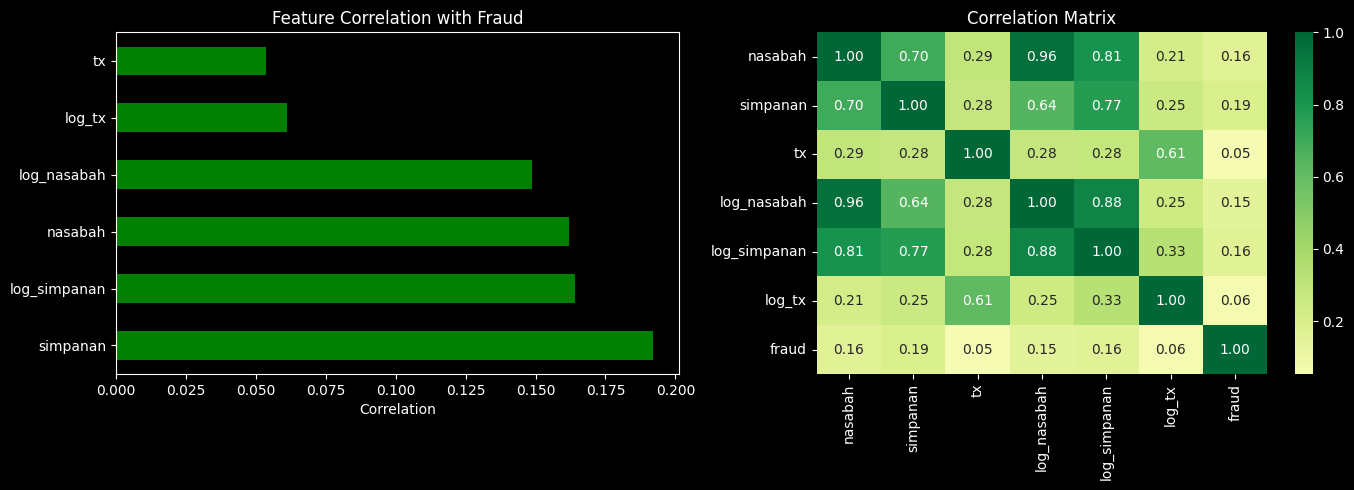


✅ EDA Complete! Check OUTPUT_DIR for saved plots.


In [12]:
# ============================================================================
# EDA 4: FEATURE CORRELATION WITH FRAUD
# ============================================================================
print("\n" + "=" * 70)
print("EDA 4: FEATURE CORRELATION")
print("=" * 70)

feature_df = pd.DataFrame({
    'nasabah': nasabah_per_pekerja.numpy(),
    'simpanan': simpanan_per_pekerja.numpy(),
    'tx': tx_per_pekerja.numpy(),
    'log_nasabah': np.log1p(nasabah_per_pekerja.numpy()),
    'log_simpanan': np.log1p(simpanan_per_pekerja.numpy()),
    'log_tx': np.log1p(tx_per_pekerja.numpy()),
    'fraud': fraud_labels.numpy(),
})

print("\n📊 CORRELATION WITH FRAUD:")
corr = feature_df.corr()['fraud'].drop('fraud').sort_values(ascending=False)
print(corr.to_string())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
colors = ['green' if c > 0 else 'red' for c in corr.values]
corr.plot(kind='barh', color=colors, ax=ax)
ax.axvline(x=0, color='white', linestyle='--', alpha=0.5)
ax.set_xlabel('Correlation'); ax.set_title('Feature Correlation with Fraud')

ax = axes[1]
sns.heatmap(feature_df.corr(), annot=True, fmt='.2f', cmap='RdYlGn', center=0, ax=ax)
ax.set_title('Correlation Matrix')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/eda_correlation.png", dpi=150)
plt.show()

print("\n✅ EDA Complete! Check OUTPUT_DIR for saved plots.")

In [13]:
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, classification_report
import seaborn as sns

---
## Step 6: Model & Training

In [17]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, Linear
from torch_geometric.loader import NeighborLoader
from sklearn.metrics import roc_auc_score, f1_score

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import NeighborLoader
from sklearn.metrics import roc_auc_score, f1_score

class FraudGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.relu(self.bn2(self.fc2(x)))
        return self.classifier(x).squeeze(-1)

print("FraudGNN defined (MLP on degree features)")

FraudGNN defined (MLP on degree features)


In [18]:
import pandas as pd

# Load labeled fraud data
fraud_df = pd.read_csv("/Volumes/Backup Plus/Zaman/graph/data/labeled_fraud.csv")

print(f"Shape: {fraud_df.shape}")
print(f"Columns: {fraud_df.columns.tolist()}")
print(f"\nFirst 5 rows:")
print(fraud_df.head())

print(f"\nLabel distribution:")
print(fraud_df['is_fraud'].value_counts() if 'is_fraud' in fraud_df.columns else "Check column name")

/var/folders/ql/9v9h7g1j4d71c841_h0dm3gw0000gn/T/ipykernel_85381/1401507002.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  fraud_df = pd.read_csv("/Volumes/Backup Plus/Zaman/graph/data/labeled_fraud.csv")


Shape: (1970876, 10)
Columns: ['Nama Pelaku', 'PN', 'Intern/ Ekstern', 'Jenis kelamin', 'Status Pelaku', 'Case-Key', 'Awal Fraud Terjadi', 'Akhir Fraud Terjadi', 'date_range', 'ds']

First 5 rows:
                Nama Pelaku      PN Intern/ Ekstern  Jenis kelamin  \
0             Anna Fitriana   53977    001_Internal  P (Perempuan)   
1             Anna Fitriana   53977    001_Internal  P (Perempuan)   
2              Dudi Budiman   69787    001_Internal  L (Laki-Laki)   
3              Dudi Budiman   69787    001_Internal  L (Laki-Laki)   
4  Pelaku_2023_sd_2025.xlsx  306940    001_Internal  P (Perempuan)   

  Status Pelaku  Case-Key Awal Fraud Terjadi Akhir Fraud Terjadi  date_range  \
0         Tetap  20230001         2022-11-29          2022-11-30  2022-11-29   
1         Tetap  20230001         2022-11-29          2022-11-30  2022-11-30   
2         Tetap  20230001         2022-11-29          2022-11-30  2022-11-29   
3         Tetap  20230001         2022-11-29          2022-11-

In [19]:
# Prepare labels from fraud CSV
print("\n" + "=" * 70)
print("STEP 6A: LOADING FRAUD LABELS FROM CSV")
print("=" * 70)

import pandas as pd
import pickle

TARGET_NODE = 'pekerja'

# Load fraud data
fraud_df = pd.read_csv("/Volumes/Backup Plus/Zaman/graph/data/labeled_fraud.csv", low_memory=False)
fraud_pns = set(fraud_df['PN'].dropna().astype(str).unique())
print(f"Unique fraud PNs from CSV: {len(fraud_pns)}")

# Load pekerja mapping
MAP_DIR = "/Volumes/Backup Plus/Zaman/graph/map_id"
with open(f"{MAP_DIR}/map_pekerja.pkl", 'rb') as f:
    pekerja_map = pickle.load(f)
pekerja_map = {str(k): v for k, v in pekerja_map.items()}

# Create labels
num_nodes = data[TARGET_NODE].num_nodes
labels = torch.zeros(num_nodes, dtype=torch.long)

fraud_count = 0
for pn in fraud_pns:
    if pn in pekerja_map:
        node_id = pekerja_map[pn]
        if node_id < num_nodes:
            labels[node_id] = 1
            fraud_count += 1

data[TARGET_NODE].y = labels

print(f"Fraud nodes matched: {fraud_count} / {len(fraud_pns)}")
print(f"Label distribution:")
print(f"  Non-fraud: {num_nodes - fraud_count:,} ({100*(num_nodes-fraud_count)/num_nodes:.2f}%)")
print(f"  Fraud:     {fraud_count:,} ({100*fraud_count/num_nodes:.2f}%)")

# Create train/val/test masks
perm = torch.randperm(num_nodes)
train_size = int(0.7 * num_nodes)
val_size = int(0.15 * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[perm[:train_size]] = True
val_mask[perm[train_size:train_size+val_size]] = True
test_mask[perm[train_size+val_size:]] = True

data[TARGET_NODE].train_mask = train_mask
data[TARGET_NODE].val_mask = val_mask
data[TARGET_NODE].test_mask = test_mask

print(f"\nData split:")
print(f"  Train: {train_mask.sum():,} | Val: {val_mask.sum():,} | Test: {test_mask.sum():,}")
print("\n✅ Real fraud labels loaded!")


STEP 6A: LOADING FRAUD LABELS FROM CSV
Unique fraud PNs from CSV: 5089
Fraud nodes matched: 528 / 5089
Label distribution:
  Non-fraud: 5,722 (91.55%)
  Fraud:     528 (8.45%)

Data split:
  Train: 4,375 | Val: 937 | Test: 938

✅ Real fraud labels loaded!


In [20]:
# Simple data loaders (no neighbor sampling needed for MLP)
print("\n" + "=" * 70)
print("STEP 6B: CREATING DATA LOADERS")
print("=" * 70)

from torch.utils.data import DataLoader, TensorDataset

# Get features and labels for pekerja
X = data[TARGET_NODE].x
y = data[TARGET_NODE].y.float()
train_mask = data[TARGET_NODE].train_mask
val_mask = data[TARGET_NODE].val_mask
test_mask = data[TARGET_NODE].test_mask

train_dataset = TensorDataset(X[train_mask], y[train_mask])
val_dataset = TensorDataset(X[val_mask], y[val_mask])
test_dataset = TensorDataset(X[test_mask], y[test_mask])

BATCH_SIZE = 256

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")


STEP 6B: CREATING DATA LOADERS
Train: 4375 | Val: 937 | Test: 938


In [21]:
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"

print("\n" + "=" * 70)
print("STEP 6C: INITIALIZING MODEL")
print("=" * 70)

in_dim = data[TARGET_NODE].x.shape[1]
model = FraudGNN(in_dim=in_dim, hidden_dim=128).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
print(f"Input features: {in_dim}")
print(f"Model parameters: {total_params:,}")
print(f"Device: {DEVICE}")


STEP 6C: INITIALIZING MODEL
Input features: 16
Model parameters: 27,521
Device: mps


In [22]:
# Training functions
def train_epoch(model, loader, optimizer, criterion, device, epoch, total_epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    
    pbar = tqdm(loader, desc=f"Epoch {epoch}/{total_epochs} [Train]", leave=False)
    for batch in pbar:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x_dict, batch.edge_index_dict)
        y = batch[TARGET_NODE].y[:out.size(0)].float()
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * y.size(0)
        pred = (torch.sigmoid(out) > 0.5).long()
        total_correct += (pred == y.long()).sum().item()
        total_samples += y.size(0)
        
        pbar.set_postfix({'loss': f"{loss.item():.4f}", 'acc': f"{100*total_correct/total_samples:.1f}%"})
    
    return total_loss / total_samples, total_correct / total_samples

@torch.no_grad()
def evaluate(model, loader, criterion, device, split_name):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    
    pbar = tqdm(loader, desc=f"[{split_name}]", leave=False)
    for batch in pbar:
        batch = batch.to(device)
        out = model(batch.x_dict, batch.edge_index_dict)
        y = batch[TARGET_NODE].y[:out.size(0)].float()
        loss = criterion(out, y)
        total_loss += loss.item() * y.size(0)
        all_preds.extend(torch.sigmoid(out).cpu().tolist())
        all_labels.extend(y.cpu().long().tolist())
    
    all_preds, all_labels = np.array(all_preds), np.array(all_labels)
    avg_loss = total_loss / len(all_labels)
    accuracy = ((all_preds > 0.5).astype(int) == all_labels).mean()
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except:
        auc = 0.0
    f1 = f1_score(all_labels, (all_preds > 0.5).astype(int), zero_division=0)
    
    return avg_loss, accuracy, auc, f1

print("Training functions defined")

Training functions defined


In [23]:
def format_time(s):
    return f"{s:.0f}s" if s < 60 else f"{s/60:.1f}m" if s < 3600 else f"{s/3600:.1f}h"

In [24]:
print("\n" + "=" * 70)
print("COMPUTING ENHANCED FEATURES FOR PEKERJA")
print("=" * 70)

import gc

TARGET_NODE = 'pekerja'
num_pekerja = data[TARGET_NODE].num_nodes
num_nasabah = data['nasabah'].num_nodes
num_simpanan = data['simpanan'].num_nodes

print(f"Pekerja: {num_pekerja:,}")

# Get is_pekerja edges
is_pekerja_edge = data[('nasabah', 'is_pekerja', 'pekerja')].edge_index
has_simpanan_edge = data[('nasabah', 'has_simpanan', 'simpanan')].edge_index
has_pinjaman_edge = data[('nasabah', 'has_pinjaman', 'pinjaman')].edge_index
debit_edge = data[('simpanan', 'debit', 'transaksi')].edge_index
credit_edge = data[('transaksi', 'credit', 'simpanan')].edge_index

# === NASABAH per PEKERJA ===
print("\n1. Counting nasabah per pekerja...")
nasabah_per_pekerja = torch.zeros(num_pekerja)
for i in range(is_pekerja_edge.shape[1]):
    nasabah_per_pekerja[is_pekerja_edge[1, i]] += 1

# === SIMPANAN per NASABAH → PEKERJA ===
print("2. Aggregating simpanan...")
simpanan_per_nasabah = torch.zeros(num_nasabah)
simpanan_per_nasabah.scatter_add_(0, has_simpanan_edge[0], torch.ones(has_simpanan_edge.shape[1]))

simpanan_per_pekerja = torch.zeros(num_pekerja)
simpanan_max_per_pekerja = torch.zeros(num_pekerja)
simpanan_min_per_pekerja = torch.full((num_pekerja,), float('inf'))

for i in range(is_pekerja_edge.shape[1]):
    nasabah_id = is_pekerja_edge[0, i].item()
    pekerja_id = is_pekerja_edge[1, i].item()
    val = simpanan_per_nasabah[nasabah_id].item()
    simpanan_per_pekerja[pekerja_id] += val
    if val > simpanan_max_per_pekerja[pekerja_id]:
        simpanan_max_per_pekerja[pekerja_id] = val
    if val < simpanan_min_per_pekerja[pekerja_id]:
        simpanan_min_per_pekerja[pekerja_id] = val

simpanan_min_per_pekerja[simpanan_min_per_pekerja == float('inf')] = 0

# === PINJAMAN per NASABAH → PEKERJA ===
print("3. Aggregating pinjaman...")
pinjaman_per_nasabah = torch.zeros(num_nasabah)
pinjaman_per_nasabah.scatter_add_(0, has_pinjaman_edge[0], torch.ones(has_pinjaman_edge.shape[1]))

pinjaman_per_pekerja = torch.zeros(num_pekerja)
for i in range(is_pekerja_edge.shape[1]):
    pinjaman_per_pekerja[is_pekerja_edge[1, i]] += pinjaman_per_nasabah[is_pekerja_edge[0, i]]

# === TX per SIMPANAN → NASABAH → PEKERJA ===
print("4. Aggregating transactions...")
tx_per_simpanan = torch.zeros(num_simpanan)
tx_per_simpanan.scatter_add_(0, debit_edge[0], torch.ones(debit_edge.shape[1]))
tx_per_simpanan.scatter_add_(0, credit_edge[1], torch.ones(credit_edge.shape[1]))

tx_per_nasabah = torch.zeros(num_nasabah)
for i in range(0, has_simpanan_edge.shape[1], 100000):
    end = min(i + 100000, has_simpanan_edge.shape[1])
    for j in range(i, end):
        tx_per_nasabah[has_simpanan_edge[0, j]] += tx_per_simpanan[has_simpanan_edge[1, j]]

tx_per_pekerja = torch.zeros(num_pekerja)
tx_max_per_pekerja = torch.zeros(num_pekerja)

for i in range(is_pekerja_edge.shape[1]):
    nasabah_id = is_pekerja_edge[0, i].item()
    pekerja_id = is_pekerja_edge[1, i].item()
    val = tx_per_nasabah[nasabah_id].item()
    tx_per_pekerja[pekerja_id] += val
    if val > tx_max_per_pekerja[pekerja_id]:
        tx_max_per_pekerja[pekerja_id] = val

# === RATIOS (important for fraud!) ===
print("5. Computing ratios...")
avg_simpanan_per_nasabah = torch.where(
    nasabah_per_pekerja > 0,
    simpanan_per_pekerja / nasabah_per_pekerja,
    torch.zeros_like(nasabah_per_pekerja)
)
avg_tx_per_nasabah = torch.where(
    nasabah_per_pekerja > 0,
    tx_per_pekerja / nasabah_per_pekerja,
    torch.zeros_like(nasabah_per_pekerja)
)
avg_tx_per_simpanan = torch.where(
    simpanan_per_pekerja > 0,
    tx_per_pekerja / simpanan_per_pekerja,
    torch.zeros_like(simpanan_per_pekerja)
)
pinjaman_ratio = torch.where(
    simpanan_per_pekerja > 0,
    pinjaman_per_pekerja / simpanan_per_pekerja,
    torch.zeros_like(pinjaman_per_pekerja)
)

# === BUILD FEATURE TENSOR ===
print("6. Building feature tensor...")
features = torch.stack([
    # Raw counts
    nasabah_per_pekerja,
    simpanan_per_pekerja,
    pinjaman_per_pekerja,
    tx_per_pekerja,
    # Max/variance indicators
    simpanan_max_per_pekerja,
    tx_max_per_pekerja,
    # Ratios (normalize behavior)
    avg_simpanan_per_nasabah,
    avg_tx_per_nasabah,
    avg_tx_per_simpanan,
    pinjaman_ratio,
    # Log transforms (handle outliers)
    torch.log1p(nasabah_per_pekerja),
    torch.log1p(simpanan_per_pekerja),
    torch.log1p(pinjaman_per_pekerja),
    torch.log1p(tx_per_pekerja),
    torch.log1p(tx_max_per_pekerja),
    # Interaction features
    nasabah_per_pekerja * avg_tx_per_nasabah,
], dim=1)

# Normalize each feature
features = (features - features.mean(0)) / (features.std(0) + 1e-6)

# Replace NaN/Inf
features = torch.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)

data[TARGET_NODE].x = features.float()

print(f"\n✅ Created {features.shape[1]} features for pekerja")
print(f"   Counts: nasabah, simpanan, pinjaman, transactions")
print(f"   Max values: simpanan_max, tx_max")
print(f"   Ratios: avg per nasabah, avg per simpanan, pinjaman ratio")
print(f"   Log transforms for outlier handling")
print(f"   Interaction: nasabah * avg_tx")

gc.collect()


COMPUTING ENHANCED FEATURES FOR PEKERJA
Pekerja: 6,250

1. Counting nasabah per pekerja...
2. Aggregating simpanan...
3. Aggregating pinjaman...
4. Aggregating transactions...
5. Computing ratios...
6. Building feature tensor...

✅ Created 16 features for pekerja
   Counts: nasabah, simpanan, pinjaman, transactions
   Max values: simpanan_max, tx_max
   Ratios: avg per nasabah, avg per simpanan, pinjaman ratio
   Log transforms for outlier handling
   Interaction: nasabah * avg_tx


62816

In [25]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, roc_curve, classification_report

print("\n" + "=" * 70)
print("STEP 6D: TRAINING")
print("=" * 70)

EPOCHS = 50
LR = 0.001
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"

# Get data
X = data[TARGET_NODE].x.float().to(DEVICE)
y = data[TARGET_NODE].y.float().to(DEVICE)
train_mask = data[TARGET_NODE].train_mask
val_mask = data[TARGET_NODE].val_mask
test_mask = data[TARGET_NODE].test_mask

# Class weights
pos_weight = (y == 0).sum() / max((y == 1).sum(), 1)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

print(f"Device: {DEVICE}")
print(f"Features: {X.shape[1]}")
print(f"Train: {train_mask.sum().item()} | Val: {val_mask.sum().item()} | Test: {test_mask.sum().item()}")
print(f"Pos weight: {pos_weight.item():.2f}")

# Simple model (MLP on features)
class FraudMLP(nn.Module):
    def __init__(self, in_dim, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)

        )
    
    def forward(self, x):
        return self.net(x).squeeze(-1)

model = FraudMLP(X.shape[1], hidden_dim=128).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

history = {'train_loss': [], 'val_loss': [], 'val_auc': [], 'val_f1': []}
best_val_auc = 0
best_epoch = 0

print("-" * 70)
start_time = time.time()

for epoch in range(1, EPOCHS + 1):
    # Train
    model.train()
    optimizer.zero_grad()
    out = model(X[train_mask])
    loss = criterion(out, y[train_mask])
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    train_loss = loss.item()
    
    # Validate
    model.eval()
    with torch.no_grad():
        val_out = model(X[val_mask])
        val_loss = criterion(val_out, y[val_mask]).item()
        val_preds = torch.sigmoid(val_out).cpu().numpy()
        val_labels = y[val_mask].cpu().numpy()
    
    try:
        val_auc = roc_auc_score(val_labels, val_preds)
    except:
        val_auc = 0.5
    val_f1 = f1_score(val_labels, (val_preds > 0.5).astype(int), zero_division=0)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_auc'].append(val_auc)
    history['val_f1'].append(val_f1)
    
    is_best = val_auc > best_val_auc
    if is_best:
        best_val_auc = val_auc
        best_epoch = epoch
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_model.pt'))
    
    if epoch % 5 == 0 or epoch == 1 or is_best:
        print(f"Epoch {epoch:2d} | Loss: {train_loss:.4f}/{val_loss:.4f} | AUC: {val_auc:.4f} | F1: {val_f1:.4f}{' ⭐' if is_best else ''}")

print("-" * 70)
print(f"Training complete in {(time.time()-start_time):.1f}s | Best Val AUC: {best_val_auc:.4f} at epoch {best_epoch}")


STEP 6D: TRAINING
Device: mps
Features: 16
Train: 4375 | Val: 937 | Test: 938
Pos weight: 10.84
Model parameters: 44,289
----------------------------------------------------------------------
Epoch  1 | Loss: 1.2744/1.2081 | AUC: 0.5472 | F1: 0.0000 ⭐
Epoch  2 | Loss: 1.2643/1.2046 | AUC: 0.6763 | F1: 0.1017 ⭐
Epoch  3 | Loss: 1.2415/1.2001 | AUC: 0.6978 | F1: 0.1770 ⭐
Epoch  4 | Loss: 1.2296/1.1943 | AUC: 0.7052 | F1: 0.2168 ⭐
Epoch  5 | Loss: 1.2284/1.1875 | AUC: 0.7112 | F1: 0.2079 ⭐
Epoch  6 | Loss: 1.2132/1.1794 | AUC: 0.7130 | F1: 0.2082 ⭐
Epoch  7 | Loss: 1.2002/1.1698 | AUC: 0.7149 | F1: 0.2127 ⭐
Epoch  8 | Loss: 1.1842/1.1591 | AUC: 0.7160 | F1: 0.2124 ⭐
Epoch  9 | Loss: 1.1822/1.1476 | AUC: 0.7171 | F1: 0.2091 ⭐
Epoch 10 | Loss: 1.1697/1.1354 | AUC: 0.7176 | F1: 0.2046 ⭐
Epoch 11 | Loss: 1.1660/1.1233 | AUC: 0.7185 | F1: 0.2035 ⭐
Epoch 12 | Loss: 1.1492/1.1113 | AUC: 0.7195 | F1: 0.2031 ⭐
Epoch 13 | Loss: 1.1396/1.0998 | AUC: 0.7198 | F1: 0.2099 ⭐
Epoch 14 | Loss: 1.1481/1.0

In [26]:
print("\n" + "=" * 70)
print("STEP 6E: FINAL EVALUATION")
print("=" * 70)

# Load best model
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'best_model.pt')))
model.eval()

with torch.no_grad():
    test_out = model(X[test_mask])
    test_preds = torch.sigmoid(test_out).cpu().numpy()
    test_labels = y[test_mask].cpu().numpy()

pred_binary = (test_preds > 0.5).astype(int)

# Metrics
try:
    test_auc = roc_auc_score(test_labels, test_preds)
except:
    test_auc = 0.5
test_f1 = f1_score(test_labels, pred_binary, zero_division=0)
test_acc = (test_labels == pred_binary).mean()

print(f"\n📊 TEST RESULTS:")
print(f"   AUC-ROC:  {test_auc:.4f}")
print(f"   F1 Score: {test_f1:.4f}")  
print(f"   Accuracy: {test_acc:.4f}")

print(f"\n📋 CLASSIFICATION REPORT:")
print(classification_report(test_labels, pred_binary, target_names=['Non-Fraud', 'Fraud']))


STEP 6E: FINAL EVALUATION

📊 TEST RESULTS:
   AUC-ROC:  0.7040
   F1 Score: 0.2471
   Accuracy: 0.5192

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   Non-Fraud       0.96      0.49      0.65       848
       Fraud       0.15      0.82      0.25        90

    accuracy                           0.52       938
   macro avg       0.55      0.65      0.45       938
weighted avg       0.88      0.52      0.61       938




STEP 6F: VISUALIZATION


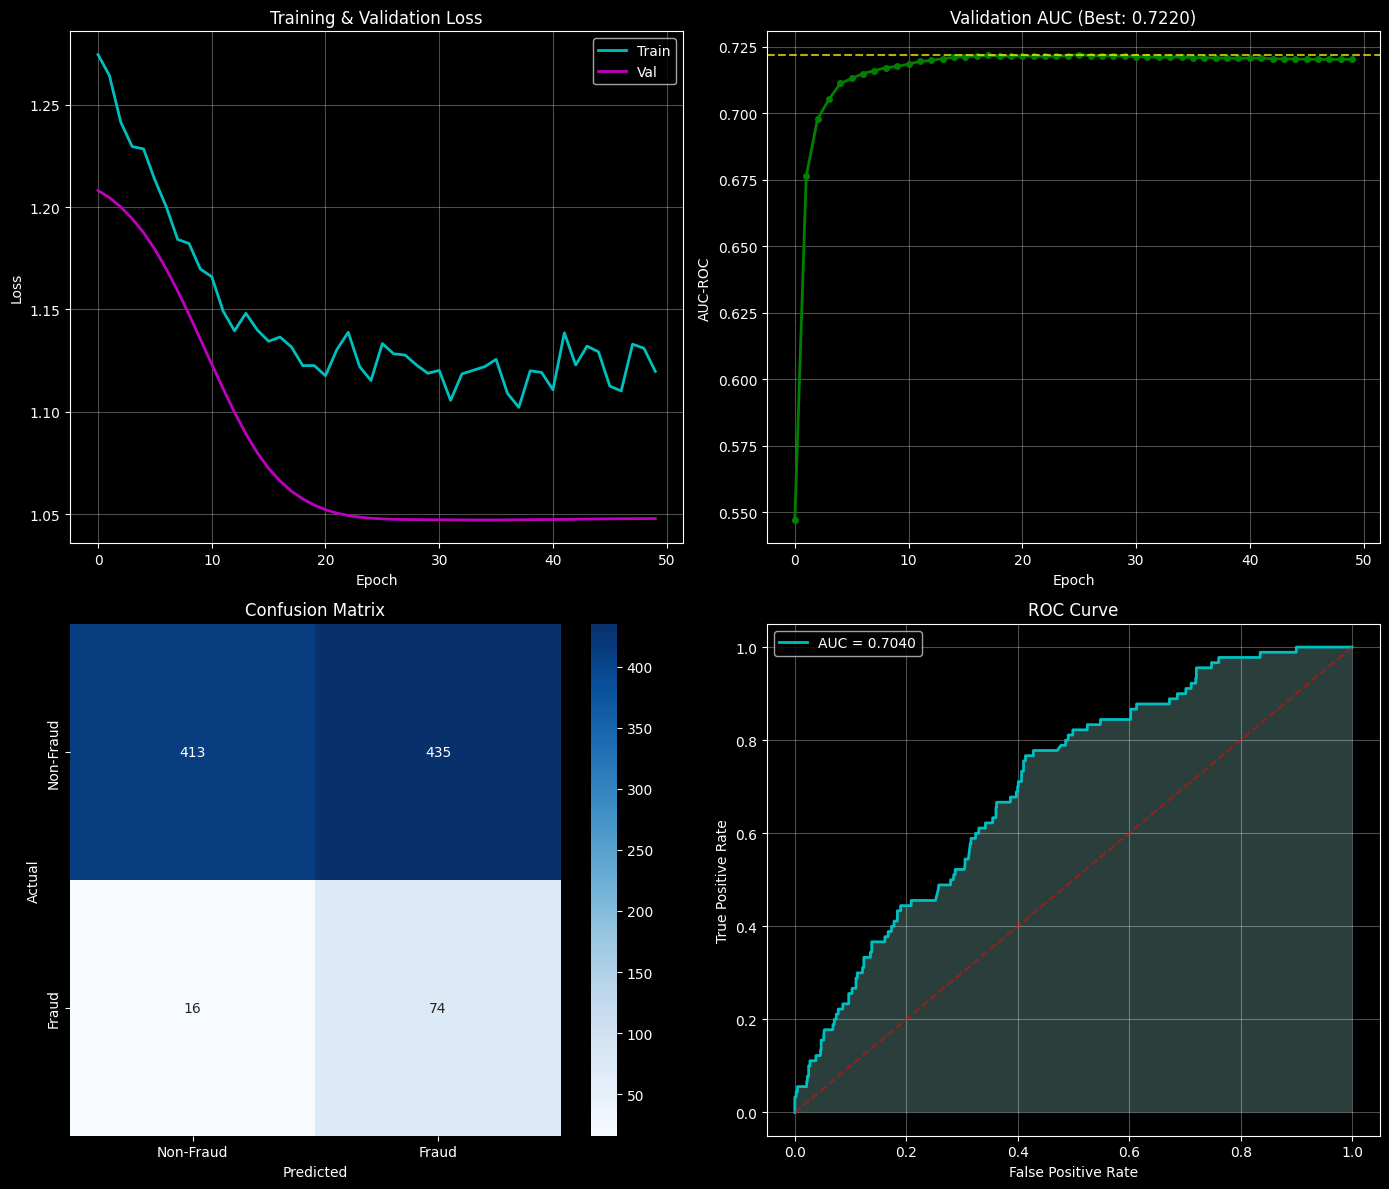


✅ Saved to /Volumes/Backup Plus/Zaman/graph/processed_fast/
   - best_model.pt
   - final_model.pt
   - training_results.png


In [27]:
print("\n" + "=" * 70)
print("STEP 6F: VISUALIZATION")
print("=" * 70)

plt.style.use('dark_background')
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Loss curves
axes[0, 0].plot(history['train_loss'], 'c-', label='Train', linewidth=2)
axes[0, 0].plot(history['val_loss'], 'm-', label='Val', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training & Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. AUC curve
axes[0, 1].plot(history['val_auc'], 'g-', linewidth=2, marker='o', markersize=4)
axes[0, 1].axhline(y=best_val_auc, color='yellow', linestyle='--', alpha=0.7)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC-ROC')
axes[0, 1].set_title(f'Validation AUC (Best: {best_val_auc:.4f})')
axes[0, 1].grid(True, alpha=0.3)

# 3. Confusion Matrix
cm = confusion_matrix(test_labels, pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
axes[1, 0].set_title('Confusion Matrix')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

# 4. ROC Curve
fpr, tpr, _ = roc_curve(test_labels, test_preds)
axes[1, 1].plot(fpr, tpr, 'c-', linewidth=2, label=f'AUC = {test_auc:.4f}')
axes[1, 1].plot([0, 1], [0, 1], 'r--', alpha=0.5)
axes[1, 1].fill_between(fpr, tpr, alpha=0.3)
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curve')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_results.png'), dpi=150)
plt.show()

# Save final model
torch.save({
    'model_state_dict': model.state_dict(),
    'test_auc': test_auc,
    'test_f1': test_f1,
    'history': history,
}, os.path.join(OUTPUT_DIR, 'final_model.pt'))

print(f"\n✅ Saved to {OUTPUT_DIR}/")
print("   - best_model.pt")
print("   - final_model.pt")
print("   - training_results.png")

XGBOOST

In [33]:
import sys
import pickle
sys.path.insert(0, '/Users/kasyfur/graph_fraud_audit/notebook_v1')

# Load pekerja map
with open(f"{MAP_DIR}/map_pekerja.pkl", 'rb') as f:
    pekerja_map = pickle.load(f)
pekerja_map = {str(k): v for k, v in pekerja_map.items()}

print("✅ Ready")

✅ Ready


In [34]:
from fraud_utils import *



FRAUD DETECTION PIPELINE
COMPUTING ENHANCED FEATURES

1. Counting nasabah per pekerja...
   Avg: 10.26
2. Aggregating simpanan...
   Avg: 816.21, Max: 70.37
3. Aggregating pinjaman...
   Avg: 130.83
4. Aggregating transactions...
   Avg: 1576.37, Max: 144.97
5. Computing ratios...
6. Building feature tensor...

✅ Created 21 features
   Counts: 4, Max: 3, Variance: 2, Ratios: 4
   Log: 4, LogMax: 2, Interactions: 2

📊 Labels: 528 fraud (8.4%), 5722 non-fraud

🚀 Training MLP: 113,921 params
   Features: 21, Epochs: 50, Pos weight: 10.84
------------------------------------------------------------
   Epoch  1 | AUC: 0.7049 | F1: 0.2165 ⭐
   Epoch  2 | AUC: 0.7083 | F1: 0.2308 ⭐
   Epoch  3 | AUC: 0.7101 | F1: 0.2316 ⭐
   Epoch  4 | AUC: 0.7120 | F1: 0.2332 ⭐
   Epoch  5 | AUC: 0.7141 | F1: 0.2347 ⭐
   Epoch 10 | AUC: 0.7229 | F1: 0.2351 ⭐
   Epoch 20 | AUC: 0.7302 | F1: 0.2392 ⭐
   Epoch 30 | AUC: 0.7287 | F1: 0.2396
   Epoch 40 | AUC: 0.7289 | F1: 0.2371
   Epoch 50 | AUC: 0.7289 | F1: 

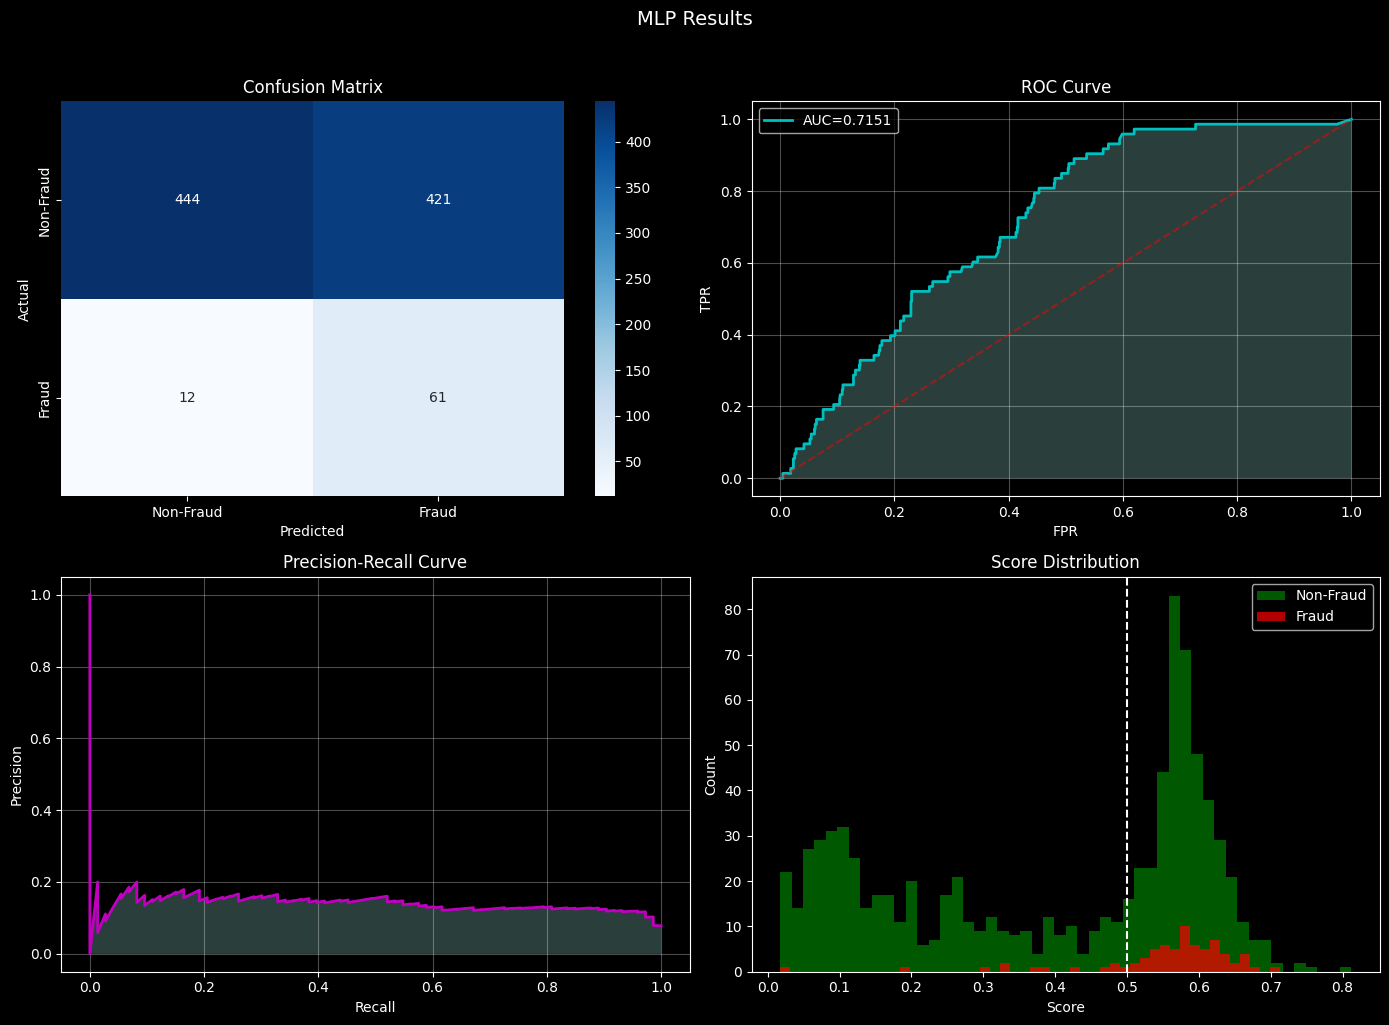


📋 Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       0.97      0.51      0.67       865
       Fraud       0.13      0.84      0.22        73

    accuracy                           0.54       938
   macro avg       0.55      0.67      0.45       938
weighted avg       0.91      0.54      0.64       938


🌲 Training XGBoost...
   Scale pos weight: 10.82
✅ XGBoost Test Results: AUC=0.6728, F1=0.2120


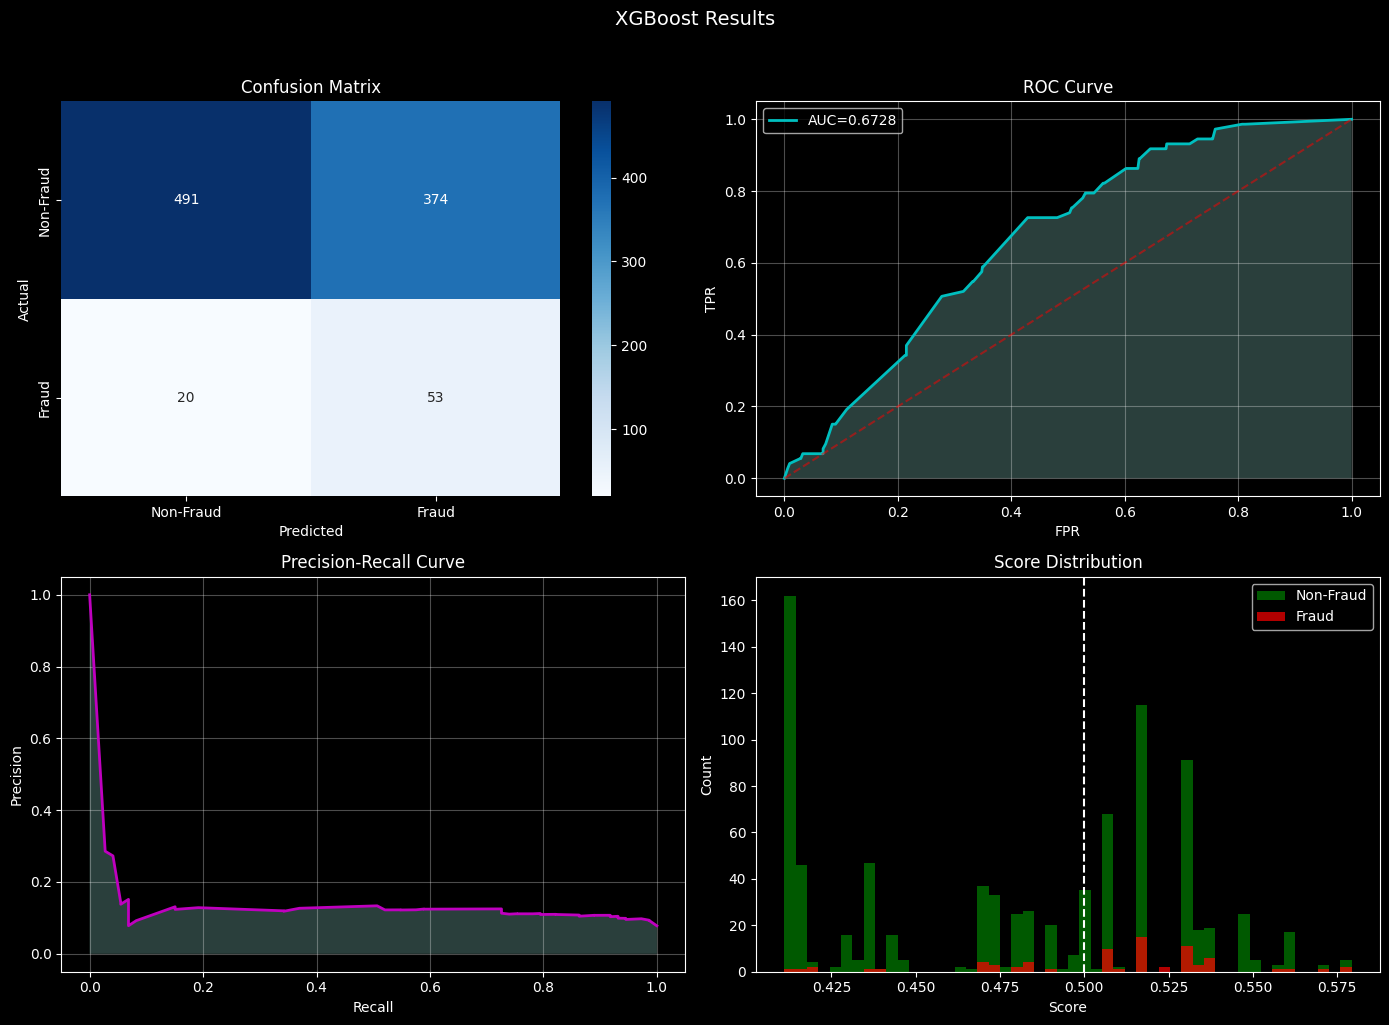


📋 Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       0.96      0.57      0.71       865
       Fraud       0.12      0.73      0.21        73

    accuracy                           0.58       938
   macro avg       0.54      0.65      0.46       938
weighted avg       0.90      0.58      0.67       938


MODEL COMPARISON
   MLP            : AUC=0.7151, F1=0.2198
   XGBoost        : AUC=0.6728, F1=0.2120

🏆 Best Model: MLP (AUC=0.7151)


In [35]:
results = run_full_pipeline(data, pekerja_map, run_xgb=True)

---
## Pipeline Complete!

**Outputs saved:**
- `heterodata.pt` - Graph data
- `node_maps.pkl` - ID mappings
- `best_model.pt` - Best model weights
- `final_model.pt` - Full checkpoint